In [60]:
from lifelines import CoxPHFitter
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy
import csv
import os
import math
from lifelines.utils import k_fold_cross_validation
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import scipy.stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from statsmodels.stats.weightstats import ztest
from scipy import interp
import subprocess
import re
import seaborn as sns
from functools import reduce

## Creazione dei dataset da Excel

In [61]:
sens=pd.read_csv('clintab_GMQL/methylation/ss_surv_meth.csv', sep='\t')
sens['class']=np.zeros(sens.shape[0], dtype=int)
sens.head()

,patient,chrom,start,stop,beta_value,gene_symbol,gene_type,ensemble_transcript_id,feature_type,pfs,pfi,os,event,class
0,SS_00000,1,924805,924806,0.010496,SAMD11,protein_coding,ENST00000342066.6|ENST00000420190.4|ENST000004...,Island,17.934426,14.0,28.655738,1,0
1,SS_00000,1,925937,925938,0.010450,SAMD11,protein_coding,ENST00000342066.6|ENST00000420190.4|ENST000004...,Island,17.934426,14.0,28.655738,1,0
2,SS_00000,1,959207,959208,0.012587,NOC2L,protein_coding,ENST00000327044.6|ENST00000469563.1|ENST000004...,Island,17.934426,14.0,28.655738,1,0
3,SS_00000,1,959574,959575,0.880483,NOC2L,protein_coding,ENST00000327044.6|ENST00000469563.1|ENST000004...,Island,17.934426,14.0,28.655738,1,0
4,SS_00000,1,966645,966646,0.012630,PLEKHN1,protein_coding,ENST00000379407.6|ENST00000379409.5|ENST000003...,Island,17.934426,14.0,28.655738,1,0


In [62]:
senl=pd.read_csv('clintab_GMQL/methylation/sl_surv_meth.csv', sep='\t')
senl['class']=np.full(senl.shape[0], 2)
#senl.head()

In [63]:
res=pd.read_csv('clintab_GMQL/methylation/res_surv_meth.csv', sep='\t')
res['class']=np.ones(res.shape[0], dtype=int)
#res.head()

In [64]:
sensitive=senl.append(sens, ignore_index=True)
all_dset1=res.append(sensitive, ignore_index=True)

#all_dset1.head()

## Significant features

In [65]:
a=pd.read_csv("new_data/methylation/res_sl_meth_pv2.csv", delimiter=',')
b=pd.read_csv("new_data/methylation/res_ss_meth_pv2.csv", delimiter=',')
c=pd.read_csv("new_data/methylation/sl_ss_meth_pv2.csv", delimiter=',')

In [66]:
lana=b.append(c, ignore_index=True, sort=True)
all_genes=a.append(lana, ignore_index=True, sort=True)
#all_genes.head()

In [67]:
ciao = all_genes[all_genes.columns[0:1]] 
ciao.head()

,gene
0,SKIV2L
1,MOCS1
2,LRRN4CL
3,THRSP
4,HSPB2


### Dataset from list of significant genes

In [68]:
lista1=set(all_genes['gene'])
#lista1=new_f
#len(lista1)

In [69]:
dset_res = res[res.gene_symbol.isin(lista1)]
res1=pd.DataFrame(dset_res)
#res1.head()

In [70]:
resdf= res1.groupby(['gene_symbol', 'patient'])['beta_value'].median().unstack(level = 0)
#resdf.head()

In [71]:
dset_sens = sens[sens.gene_symbol.isin(lista1)]
sens1=pd.DataFrame(dset_sens)
#sens1.head()

In [72]:
sensdf= sens1.groupby(['gene_symbol', 'patient'])['beta_value'].median().unstack(level = 0)
#sensdf.head()

In [73]:
dset_senl = senl[senl.gene_symbol.isin(lista1)]
senl1=pd.DataFrame(dset_senl)
#senl1.head()

In [74]:
senldf= senl1.groupby(['gene_symbol', 'patient'])['beta_value'].median().unstack(level = 0)
#senldf.head()

In [75]:
sen_conc=pd.concat([senldf, sensdf])
all_conc=pd.concat([sen_conc, resdf])

In [76]:
all_conc.head()
#all_conc.shape

gene_symbol,AGO1,ALPK3,CATIP-AS2,CBLN4,CRYAB,CTC-543D15.3,CTPS1,FBXO48,GHSR,HSPB2,...,RP11-886P16.10,SEMA3G,SKIV2L,SLC2A14,TGM1,THRSP,TRAPPC4,VDAC3,VPS37B,ZNF560
patient,,,,,,,,,,,,,,,,,,,,,
SL_00000,0.016051,0.944771,0.926125,0.272748,0.064485,0.925017,0.274870,0.036465,0.665635,0.507872,...,0.025097,0.959752,0.932630,0.614379,0.761385,0.169713,0.031782,0.275955,0.483716,0.936046
SL_00001,0.012651,0.558569,0.897421,0.225941,0.370748,0.678537,0.270869,0.023453,0.629792,0.793318,...,0.019223,0.985533,0.923757,0.766650,0.904406,0.967065,0.029116,0.270904,0.305452,0.638086
SL_00002,0.018730,0.957683,0.948455,0.130589,0.233246,0.924222,0.063129,0.036404,0.064935,0.754209,...,0.021861,0.956035,0.946057,0.766249,0.768642,0.979199,0.024556,0.456719,0.453627,0.933475
SL_00003,0.019855,0.927138,0.952317,0.383354,0.385329,0.213985,0.336583,0.038373,0.510115,0.648863,...,0.032079,0.948914,0.914845,0.299647,0.727130,0.720289,0.036748,0.450554,0.460353,0.067281
SL_00004,0.019843,0.928851,0.953204,0.243153,0.334772,0.550735,0.110536,0.037299,0.179736,0.674981,...,0.045006,0.945656,0.904755,0.503075,0.806280,0.946500,0.024663,0.429098,0.399994,0.071509


### Adding pfs, class, event, overall survival, pfi

In [77]:
lista2=set(all_dset1['pfs'])
lista3=set(all_dset1['event'])
lista4=set(all_dset1['pfi'])
lista5=set(all_dset1['os'])

In [78]:
gr=all_dset1.groupby(['patient'])

In [79]:
pfs=[]
e=[]
os=[]
pfi=[]
classes=[]
for p in gr.groups.keys():
    g=gr.get_group(p)
    pfs.append(g['pfs'].unique()[0])
    e.append(g['event'].unique()[0])
    os.append(g['os'].unique()[0])
    pfi.append(g['pfi'].unique()[0])
    classes.append(g['class'].unique()[0])
   

In [80]:
all_conc['pfs']=pfs
all_conc['event']=e
all_conc['ov_sur']=os
all_conc['pfi']=pfi
#all_conc['class']=classes

all_conc.head()

gene_symbol,AGO1,ALPK3,CATIP-AS2,CBLN4,CRYAB,CTC-543D15.3,CTPS1,FBXO48,GHSR,HSPB2,...,TGM1,THRSP,TRAPPC4,VDAC3,VPS37B,ZNF560,pfs,event,ov_sur,pfi
patient,,,,,,,,,,,,,,,,,,,,,
SL_00000,0.016051,0.944771,0.926125,0.272748,0.064485,0.925017,0.274870,0.036465,0.665635,0.507872,...,0.761385,0.169713,0.031782,0.275955,0.483716,0.936046,5.901639,1,68.098361,-1.8
SL_00001,0.012651,0.558569,0.897421,0.225941,0.370748,0.678537,0.270869,0.023453,0.629792,0.793318,...,0.904406,0.967065,0.029116,0.270904,0.305452,0.638086,8.295082,1,15.147541,4.3
SL_00002,0.018730,0.957683,0.948455,0.130589,0.233246,0.924222,0.063129,0.036404,0.064935,0.754209,...,0.768642,0.979199,0.024556,0.456719,0.453627,0.933475,10.590164,1,12.426230,5.2
SL_00003,0.019855,0.927138,0.952317,0.383354,0.385329,0.213985,0.336583,0.038373,0.510115,0.648863,...,0.727130,0.720289,0.036748,0.450554,0.460353,0.067281,5.967213,1,12.098361,-0.8
SL_00004,0.019843,0.928851,0.953204,0.243153,0.334772,0.550735,0.110536,0.037299,0.179736,0.674981,...,0.806280,0.946500,0.024663,0.429098,0.399994,0.071509,9.278689,1,91.409836,5.2


In [81]:
#all_conc.to_csv('all_conc_meth.csv', sep=',', header=True, index=True)

In [ ]:
x=all_conc.copy()
#x=x.drop(['ov_sur', 'pfi', 'AGO1', 'ALPK3', 'CTC-543D15.3', 'FBXO48', 'LRRN4CL', 'MOCS1', 'PFN1P11', 'PLCE1', 'PLEKHB1', 'THRSP', 'RILP', 'RP11-886P16.10', 'SEMA3G', 'SKIV2L', 'TGM1', 'TRAPPC4', 'ZNF560', 'HSPB2'], axis=1)
x=x.drop(['ov_sur', 'pfi', 'pfs', 'event'], axis=1) #questo serve per plottare la correlation matrix, quello sopra per SA
x_all=x.values
y_all= classes
x.head()
#x=pd.DataFrame(x)

In [ ]:
import seaborn as sns
corr = x.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
no_nan=corr.fillna(value=0)

In [ ]:
finito=False
new_f=[]
feat=list(no_nan.columns)

while finito==False:
    f=feat[0]

    for r2 in no_nan.columns:
        if r2 != f and no_nan[f][r2] >= 0.7:
            if r2 in feat:
                feat.remove(r2)
    
    new_f.append(f)
    feat.remove(f)
    
    if len(feat) == 0:
        finito=True

In [ ]:
len(new_f)

In [82]:
#x.head()
y=all_conc.copy()
#y=y.drop(['ov_sur', 'pfi', 'AGO1', 'ALPK3', 'CTC-543D15.3', 'FBXO48', 'LRRN4CL', 'MOCS1', 'PFN1P11', 'PLCE1', 'PLEKHB1', 'THRSP', 'RILP', 'RP11-886P16.10', 'SEMA3G', 'SKIV2L', 'TGM1', 'TRAPPC4', 'ZNF560', 'KRT73-AS1'], axis=1)
y=y.drop(['ov_sur', 'pfi', 'CTC-543D15.3', 'VDAC3','ALPK3','TGM1','TRAPPC4','AGO1','RP11-886P16.10','PLEKHB1','MPG','PFN1P11',
          'GHSR','MKNK1','CTPS1','RILP','ZNF560','SEMA3G','CBLN4','LRRN4CL','PLCE1','SKIV2L','FBXO48','HSPB2','KRT73-AS1',
          'MOCS1','OLFM2', 'CATIP-AS2'], axis=1) 
y_all=y.values
#['SKIV2L', 'RILP', 'PLEKHB1']
#
y.head()

gene_symbol,CRYAB,PTGIR,SLC2A14,THRSP,VPS37B,pfs,event
patient,,,,,,,
SL_00000,0.064485,0.961949,0.614379,0.169713,0.483716,5.901639,1
SL_00001,0.370748,0.954986,0.766650,0.967065,0.305452,8.295082,1
SL_00002,0.233246,0.971213,0.766249,0.979199,0.453627,10.590164,1
SL_00003,0.385329,0.945789,0.299647,0.720289,0.460353,5.967213,1
SL_00004,0.334772,0.948281,0.503075,0.946500,0.399994,9.278689,1


In [83]:
x=y.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)

In [25]:
from sklearn.model_selection import train_test_split
x_new=x.copy()
x_new=x_new.drop('pfs', axis=1)
X_train, X_test, y_train, y_test = train_test_split(x_new, x['pfs'], test_size=0.2)
X_train['pfs']= y_train
X_test['pfs']= y_test

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(X_train, 'pfs', event_col='event', show_progress=True)

Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -869.63882, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 5 iterations.


<lifelines.CoxPHFitter: fitted with 217 observations, 25 censored>

In [27]:
res=[]
sens=[]
senl=[]

for p in X_test.index:
    if 'R' in p:
        res.append(p)
    elif 'SS' in p:
        sens.append(p)
    else:
        senl.append(p)

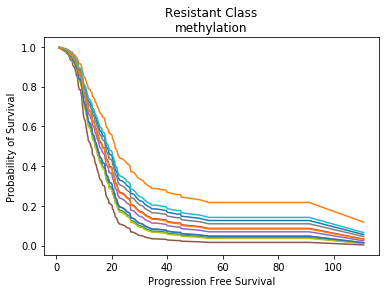

In [31]:
plt.plot(cph.predict_survival_function(X_test.loc[res]))
plt.xlabel('Progression Free Survival')
plt.ylabel('Probability of Survival')
plt.title('Resistant Class\nmethylation')
plt.show()

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
print(scaler.fit(y))
StandardScaler(copy=True, with_mean=True, with_std=True)
print(scaler.mean_)
df_scal=scaler.transform(y)
df_scal=pd.DataFrame(df_scal, columns=y.columns)
print(df_scal)

StandardScaler(copy=True, with_mean=True, with_std=True)
[ 0.22676951  0.89836326  0.37378662  0.45404347  0.29164143 20.53266635
  0.87132353]
gene_symbol     CRYAB     PTGIR   SLC2A14     THRSP    VPS37B       pfs  \
0           -1.340180  0.847690  0.927412 -0.979552  1.321001 -0.854900   
1            1.189004  0.754874  1.514373  1.767421  0.094982 -0.715049   
2            0.053483  0.971200  1.512826  1.809225  1.114066 -0.580946   
3            1.309417  0.632254 -0.285784  0.917249  1.160327 -0.851068   
4            0.891907  0.665477  0.498370  1.696573  0.745204 -0.657577   
5            1.833463  0.992160  0.984119  1.127616  1.227466 -0.906625   
6            1.450227  0.617984  1.133902 -0.612588 -0.183158 -0.625009   
7            0.836824 -0.656618  0.745408  0.612835  0.486838 -0.628840   
8            2.130809  0.898232  0.909859  1.788494  1.021548 -0.657577   
9            0.203476  0.485166  0.893213 -0.640032  0.913804 -0.632672   
10          -0.332748 -0.162758

In [85]:
df_s=df_scal.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)

Iteration 8: norm_delta = 0.00000, step_size = 1.0000, ll = -1245.00021, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 8 iterations.
<lifelines.CoxPHFitter: fitted with 272 observations, 0 censored>
      duration col = 'pfs'
         event col = 'event'
         penalizer = 0.0001
number of subjects = 272
  number of events = 272
partial log-likelihood = -1245.00
  time fit was run = 2019-10-16 10:52:43 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
gene_symbol                                                                                                  
CRYAB        0.29      1.33      0.08            0.13            0.44                1.14                1.55
PTGIR       -0.13      0.88      0.07           -0.27            0.01                0.77                1.01
THRSP       -0.19      0.82      0.08           -0.35           -0.04                0.71                0.9

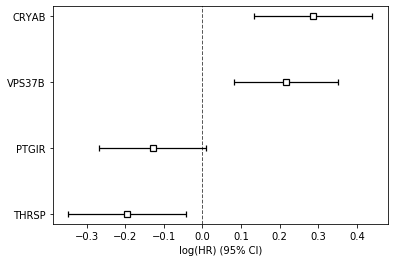

In [86]:
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(df_s, duration_col='pfs', event_col='event', show_progress=True, step_size=0.5)
cph.print_summary()
cph.baseline_cumulative_hazard_.shape
cph.plot()

In [58]:
k_fold = k_fold_cross_validation(cph, df_s, duration_col='pfs', event_col='event', k=5, predictor='predict_median')

In [ ]:
w=np.mean(k_fold)
w
#k_fold

In [ ]:
k_fold

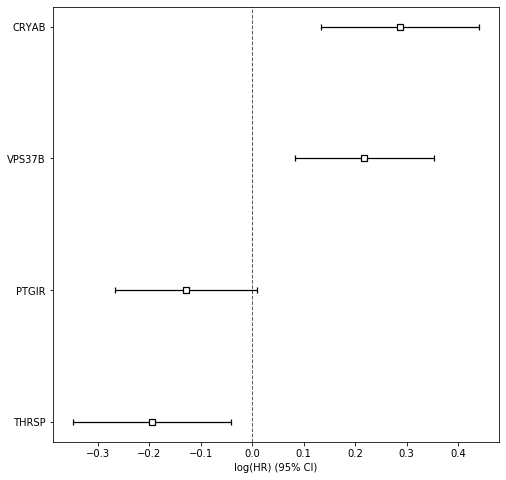

In [90]:
plt.rcParams["figure.figsize"] = [8, 8]
cph.plot()

## Prove

In [ ]:
cph.fit(all_conc, duration_col='pfs', event_col='event', show_progress=True)

cph.plot_covariate_groups('ENSG00000135443.7', [0, 1, 2], cmap='coolwarm')

In [ ]:
#prediction(?)

from lifelines import WeibullAFTFitter
aft_with_elastic_penalty = WeibullAFTFitter(penalizer=4.0, l1_ratio=1.0)
aft_with_elastic_penalty.fit(all_conc, 'pfs', 'event')
aft_with_elastic_penalty.predict_median(all_conc)

aft_with_elastic_penalty.print_summary()

In [ ]:
#Model selection for AFT models
from lifelines import LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter

llf = LogLogisticAFTFitter().fit(all_conc, 'pfs', 'event')
lnf = LogNormalAFTFitter().fit(all_conc, 'pfs', 'event')
wf = WeibullAFTFitter().fit(all_conc, 'pfs', 'event')

print(llf.log_likelihood_) 
print(lnf.log_likelihood_)  
print(wf.log_likelihood_)   


# with some heterogeneity in the ancillary parameters
#ancillary_df = all_conc[['class']]
#llf = LogLogisticAFTFitter().fit(all_conc, 'pfs', 'event', ancillary_df=ancillary_df)
#lnf = LogNormalAFTFitter().fit(all_conc, 'pfs', 'event', ancillary_df=ancillary_df)
#wf = WeibullAFTFitter().fit(all_conc, 'pfs', 'event', ancillary_df=ancillary_df)

#print(llf.log_likelihood_) 
#print(lnf.log_likelihood_) 
#print(wf.log_likelihood_)  

In [ ]:
all_conc['ENSG00000135443.7']

In [ ]:
cph.check_assumptions(all_conc, p_value_threshold=0.05, show_plots=True)